# Aprendizaje sin supervisión

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


La mayoría de los datos disponibles en el mundo real no tienen etiquetas. Hay que aplicar métodos que no requieren supervisión

Hemos visto un ejemplo de un método así: reducción de dimensionalidad.

Ahora veremos:

* *Clustering*: agrupar instancias similares en cúmulos.
* Detección de anomalías: aprender como son datos "normales" para detectar datos "raros" (*outliers*).
* Estimación de densidad: estimar la función de densidad de probabilidad del proceso aleatorio que generó el conjunto de datos. Útil para detección de anomalías, analisis y visualización.

## *Clustering*

![](figures_sin_supervision/fig9-1.png)

Sin etiquetas es difícil separar los cúmulos de puntos. En este caso hay más *features* que ayudan con encontrar una buena separación.

### K-Means

![](figures_sin_supervision/fig9-2.png)

*K-Means* funciona bastante bien con datos así, puede encontrar los cúmulos rápidamente.

In [4]:
from sklearn.datasets import make_blobs

In [5]:
blob_centers = array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = array([0.4, 0.3, 0.1, 0.1, 0.1])

In [6]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

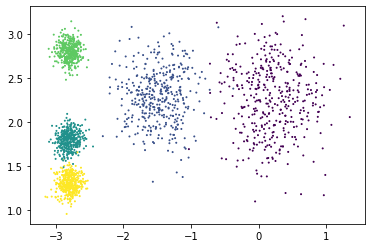

In [7]:
scatter(X[:, 0], X[:, 1], c=y, s=1)

In [8]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [9]:
y_pred

array([0, 4, 1, ..., 2, 1, 4], dtype=int32)

El algoritmo asigna etiquetas a los puntos según los cúmulos que identifica.

Podemos ver los centros de los $5$ cúmulos:

In [10]:
kmeans.cluster_centers_

array([[-2.80095255,  1.30278669],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80334072,  1.80296136]])

Podemos asignar instancias nuevas al cúmulo más cerca:

In [11]:
X_new = array([[0,2],[3,2],[-3,3],[-3,2.5]])

In [12]:
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

Una visualización de los límites de decisión del método resulta en una **teselación de Voronoi**.

![](figures_sin_supervision/fig9-3.png)

La gran mayoría de las instancias están asignadas al cúmulo correcto, pero algunas no.

Podemos ver las distancias entre cada instancia y los centros de los cúmulos con el método `transform()`.

In [13]:
kmeans.transform(X_new)

array([[2.88642367, 0.32995317, 2.9042344 , 1.49439034, 2.81025683],
       [5.84270116, 2.80290755, 5.84739223, 4.4759332 , 5.80668475],
       [1.70884549, 3.29399768, 0.29040966, 1.69136631, 1.21308547],
       [1.21364722, 3.21806371, 0.36159148, 1.54808703, 0.72424977]])

Si tenemos un conjunto de datos de muy alta dimensionalidad, podemos usar estas distancias como un conjunto de $k$ dimensiones: una forma de reducir la dimensionalidad de los datos!

##### Algoritmo:

1. Elegir aleatoriamente los centros de los cúmulos
2. Asignar etiquetas a las instancias según el centro de cúmulo más cercano.
3. Actualizar los centros usando las instancias etiquetadas.
4. Repetir el proceso hasta que los centros no se muevan más.

![](figures_sin_supervision/fig9-4.png)

Convergencia del algoritmo está garantizado, pero por la elección aleatoria de los centros, a veces encuentra una solución sub-óptima...

![](figures_sin_supervision/fig9-5.png)

Podemos elegir los centros iniciales si sabemos más o menos donde están, con `init` (y poniendo `n_init=1`).

In [18]:
good_init = array([[-3,3],[-3,2],[-3,1],[-1,2],[0,2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

Otra solución es aplicar el algoritmo varias veces variando las posiciones iniciales de los centros, para encontrar la mejor solución.

Se puede controlar el número de veces con `n_init` (por defecto igual a $10$).

La metrica usada para decidir la mejor solución es la **inercia**: la distancia promedia cuadrada entre cada instancia y el cúmulo más cercano.

*K-Means* elige la solución con la inercia más baja.

In [20]:
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [21]:
kmeans.inertia_

211.60132229528597

El método `score()` retorna la inercia negativa, considerando un valor más cerca a cero como mejor puntaje.

In [22]:
kmeans.score(X)

-211.601322295286

Una modificación del proceso de inicializar los centros fue propuesta en 2006. El algoritmo se llama *K-Means++*. Scikit-Learn utiliza *K-Means++* por defecto.

Algoritmo:

1. Elegir un centro $\boldsymbol{c}^{(1)}$ aleatoriamente del conjunto de datos.
2. Elegir un centro nuevo $\boldsymbol{c}^{(i)}$, eligiendo una instancia $\boldsymbol{x}^{(i)}$ con probabilidad $D(\boldsymbol{x}^{(i)})^2 \sum_{j=1}^m D(\boldsymbol{x}^{(j)})^2$ donde $D(\boldsymbol{x}^{(i)})$ es la distancia entre la instancia $\boldsymbol{x}^{(i)}$ y el centro más cercano ya elegido. Así es mucho más probable elegir instancias más lejanas de los centros ya elegidos como centros.
3. Repetir paso 2 hasta que los $k$ centros estén elegidos.

Con `init="random"` podemos usar el método "tradicional".

### Encontrando el número óptimo de cúmulos

Muchas veces no es posible saber cuál valor elegir para $k$... Si elegimos un valor no óptimo para $k$ los resultados pueden ser bastante malos:

![](figures_sin_supervision/fig9-7.png)

No podemos elegir el modelo con un mínimo de **inercia** ya que sigue reduciendose con mayor $k$.

![](figures_sin_supervision/fig9-8.png)

Podríamos elegir el "codo" donde la inercia no se reduce mucho más.

Otro método mejor es usar **puntaje de silueta** (*silhouette score*). Este es el promedio del coeficiente de silueta sobre todas las instancias:

$$SS = \frac{(b - a)}{\text{max}(a,b)}$$

donde $a$ es la distancia promedia a las otras instancias en el mismo cúmulo, $b$ es la distancia promedia a las instancias en el próximo cúmulo más cercano.

Tenemos que $-1 \leq SS \leq +1$.

* $SS \approx +1$ la instancia está bien adentro de su cúmulo y lejos de los otros.
* $SS \approx 0$: la instancia está cerca del límite de un cúmulo.
* $SS \approx -1$: probablemente la instancia estaba asignada al cúmulo incorrecto.

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

Comparamos los *silhouette scores* variando el número de cúmulos:

![](figures_sin_supervision/fig9-9.png)

Se puede obtener una visualización aún más informativa graficando el coeficiente de silueta para cada instancia, ordenado por el cúmulo a cuál están asignados y por el valor del coeficiente.

![](figures_sin_supervision/fig9-10.png)

La línea vertical da el puntaje de silueta total (del gráfico anterior).

Cuando la mayoría de las instancias en un cúmulo tienen un coeficiente menor del puntaje total significa que están demasiado cerca a otros cúmulos.

En el caso de $k=4$ hay un cúmulo un poco grande, así que $k=5$ es mejor.

#### Limitaciones de *K-Means*

* Hay que correr el algoritmo varias veces para evitar soluciones sub-óptimos.
* Hay que especificar el número de cúmulos.
* No funciona muy bien cuando los cúmulos tienen tamaños distintos, densidades diferentes o formas no-esféricas.

![](figures_sin_supervision/fig9-11.png)

#### Aplicaciones de *clustering*

* Segmentación de imagenes: asignando pixeles a distintos cúmulos según una clasificación (objeto, color, etc.)
* Reducción de dimensionalidad
* Aprendizaje semi-supervisado

### Aprendizaje semi-supervisado

